## Importing Libraries 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import copy

from tslib.src import tsUtils
# from tslib.src.synthcontrol import RobustSynthaticControl
from tslib.tests import testdata

In [7]:
################################################################
#
# Robust Synthetic Control 
#
# Implementation based on: 
# http://www.jmlr.org/papers/volume19/17-777/17-777.pdf
#
################################################################
import numpy as np
import pandas as pd

from tslib.src.models.tsSVDModel import SVDModel
from tslib.src.models.tsALSModel import ALSModel
from tslib.src import tsUtils

class RobustSyntheticControl(object):
    
    # seriesToPredictKey:       (string) the series of interest (key)
    # kSingularValuesToKeep:    (int) the number of singular values to retain
    # M:                        (int) the number of columns for the matrix
    # probObservation:          (float) the independent probability of observation of each entry in the matrix
    # modelType:                (string) SVD or ALS. Default is "SVD"
    # svdMethod:                (string) the SVD method to use (optional)
    # otherSeriesKeysArray:     (array) an array of keys for other series which will be used to predict 

    def __init__(self, seriesToPredictKey, kSingularValuesToKeep, M, probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=[]):

        self.seriesToPredictKey = seriesToPredictKey
        self.otherSeriesKeysArray = otherSeriesKeysArray

        self.N = 1 # each series is on its own row
        self.M = M

        self.kSingularValues = kSingularValuesToKeep
        self.svdMethod = svdMethod

        self.p = probObservation

        if (modelType == 'als'):
            self.model = ALSModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        elif (modelType == 'svd'):
            self.model = SVDModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, svdMethod='numpy', otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        else:
            self.model = SVDModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, svdMethod='numpy', otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        self.control = None # these are the synthetic control weights


    # keyToSeriesDictionary: (Pandas dataframe) a key-value Series
    # Note that the keys provided in the constructor MUST all be present
    # The values must be all numpy arrays of floats.
    def fit(self, keyToSeriesDF):
        self.model.fit(keyToSeriesDF)


    # otherKeysToSeriesDFNew:     (Pandas dataframe) needs to contain all keys provided in the model;
    #                               all series/array MUST be of length >= 1, 
    #                               If longer than 1, then the most recent point will be used (for each series)
    def predict(self, otherKeysToSeriesDFNew):
        prediction = np.dot(self.model.weights, otherKeysToSeriesDFNew[self.otherSeriesKeysArray].T)
        return prediction

    # return the synthetic control weights
    def getControl():
        if (self.model.weights is None):
            raise Exception('Before calling getControl() you need to call the fit() method first.')
        else:
            return self.model.weights

## Input Variables 

In [9]:
target=input('Enter the state ')

Enter the state Kansas


In [10]:
county=input('Enter the county in that state ')

Enter the county in that state Wyandotte


In [11]:
date=input('Enter the intervention date in %y-%m-%d format ')

Enter the intervention date in %y-%m-%d format 2020-07-03


In [36]:
print('Enter the time period in which you want to check')
start=input('Starting date in %y-%m-%d format ')
end=input('Ending date in %y-%m-%d format ')

Enter the time period in which you want to check
Starting date in %y-%m-%d format 2020-03-10
Ending date in %y-%m-%d format 2020-07-20


## Import Data

In [22]:
url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
state = pd.read_csv(url,index_col=0)

In [25]:
state=state[state['state']==target]

In [26]:
state=state.pivot_table(index='county', columns='date', values='cases').fillna(0) 

In [27]:
state.head()

date,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,...,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27
county,,,,,,,,,,,,,,,,,,,,,
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
Atchison,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,99.0,99.0,99.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0
Barber,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Barton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.0,189.0,198.0,210.0,210.0,210.0,223.0,223.0,251.0,251.0


## Finding Similar Counties 

In [28]:
intervention=state.columns.get_loc(date)

lags=[1,7,14] #You can change lags if you want 
def cum_cases(lags):
    for i in lags:
        state[i]=pd.DataFrame(state.iloc[:, :intervention-i].sum(axis=1)) #cummulative number of cases
    return state

In [29]:
cum_cases(lags)
similar=state.iloc[:,len(state.columns)-3:] 

In [30]:
similar

date,1,7,14
county,,,
Allen,39.0,11.0,4.0
Anderson,89.0,68.0,47.0
Atchison,1402.0,1223.0,1037.0
Barber,86.0,80.0,73.0
Barton,2594.0,2260.0,1885.0
...,...,...,...
Washington,22.0,16.0,9.0
Wichita,0.0,0.0,0.0
Wilson,77.0,70.0,63.0


### Euclidien Distance to get similar counties based on trend in covid cases

In [31]:
def find_closest_counties(df, county):
    new_df = pd.DataFrame(columns = [county])
    for value in (df.index):
        new_df.loc[value] = (((df.loc[county] - df.loc[value])**2).sum())**0.5
    return new_df

In [32]:
cnts_in_snthtc_ctrl_mdl = 10 #Looking for the 10 closest counties (easy to change to any number)
county_of_interest = county #This is a county that opted
counties_to_create_counterfactual = list(find_closest_counties(similar, county_of_interest).
                                         dropna().
                                         sort_values(by = county_of_interest).
                                         head(cnts_in_snthtc_ctrl_mdl).
                                         index)

In [33]:
counties_to_create_counterfactual ###Similar Counties to our target value 

['Wyandotte',
 'Ford',
 'Finney',
 'Leavenworth',
 'Johnson',
 'Seward',
 'Sedgwick',
 'Lyon',
 'Shawnee',
 'Douglas']

## Finalizing Donor Pool

In [34]:
### The final pool will be the target value + counties that did not enact mask mandates

In [35]:
dPool=['Wyandotte',
 'Ford',
 'Finney',
 'Leavenworth',
 'Seward',
 'Sedgwick',
 'Lyon']

## Performing Synthetic Control

In [37]:
data=df[df['state']==target]
data=data.pivot_table(index='county', columns='date', values='cases').fillna(0)
data=data.iloc[:,data.columns.get_loc(start):data.columns.get_loc(end)]
data=data.reset_index()
data=data.loc[data['county'].isin(dPool)]
data

date,county,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,...,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19
27,Finney,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1604.0,1604.0,1604.0,1605.0,1608.0,1613.0,1620.0,1624.0,1624.0,1624.0
28,Ford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,2028.0,2028.0,2028.0,2039.0,2039.0,2046.0,2046.0,2053.0,2053.0,2053.0
51,Leavenworth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1232.0,1232.0,1232.0,1248.0,1248.0,1264.0,1264.0,1274.0,1274.0,1274.0
55,Lyon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,523.0,523.0,523.0,532.0,533.0,536.0,543.0,550.0,550.0,550.0
86,Sedgwick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2074.0,2074.0,2074.0,2422.0,2422.0,2595.0,2595.0,2790.0,2790.0,2790.0
87,Seward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1082.0,1082.0,1082.0,1097.0,1097.0,1105.0,1105.0,1105.0,1105.0,1105.0
105,Wyandotte,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,...,2930.0,3032.0,3143.0,3169.0,3206.0,3391.0,3411.0,3603.0,3610.0,3748.0


In [38]:
allColumns = data.columns.values
states = list(np.unique(data['county']))
years = np.delete(allColumns, [0])
caStateKey = county
states.remove(caStateKey)
otherStates = states
p = 1.0
yearTrainEnd = date

In [39]:
testYears=list(years)[list(years).index(date)+1:len(list(years))]
trainingYears=list(years)[list(years).index(start):list(years).index(date)+1]
trainDataMasterDict = {}
trainDataDict = {}
testDataDict = {}

In [40]:
for key in otherStates:
 series =data.loc[data['county'] == key]

 trainDataMasterDict.update({key: series[trainingYears].values[0]})

 # randomly hide training data
 (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
 trainDataDict.update({key: trainData})
 testDataDict.update({key: series[testYears].values[0]})
    
series = data[data['county'] == caStateKey]
trainDataMasterDict.update({caStateKey: series[trainingYears].values[0]})
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)

In [41]:
singvals = 4
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()

predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
actual = data.loc[data['county'] == caStateKey]
actual = actual.drop('county', axis=1)
actual = actual.iloc[0]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

## Ploting graph

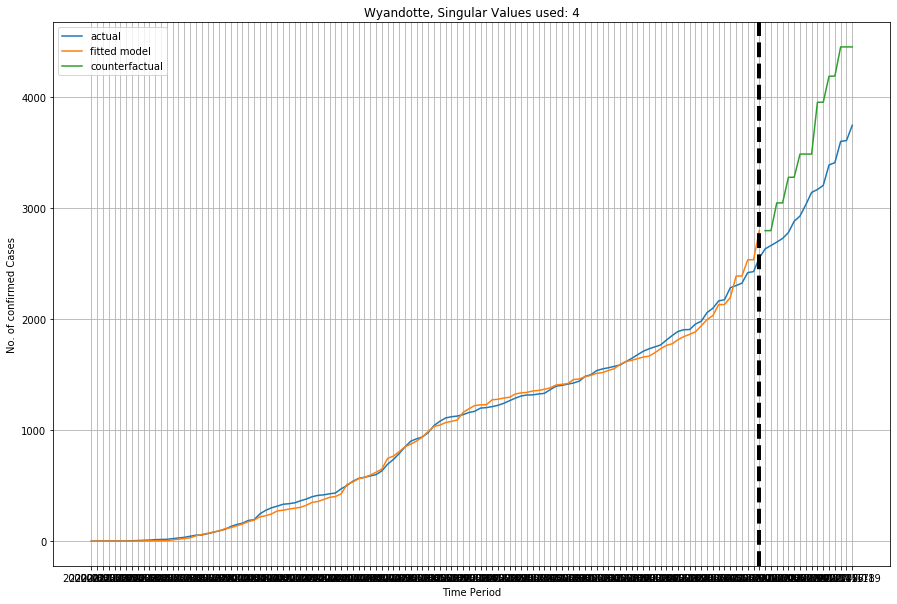

In [45]:
# fig,ax = plt.subplots(1,1)
# fig.autofmt_xdate()
plt.figure(figsize=(15,10))
tick_spacing = 1
intDate=yearTrainEnd
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

# ax.set_xticks(np.arange(len(label_markings)))
# ax.set_xticklabels(label_markings, rotation=45)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.plot(years, actual ,label='actual')
plt.xlabel('Time Period')
plt.ylabel('No. of confirmed Cases')
plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')
plt.title(caStateKey+', Singular Values used: '+str(singvals))

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(intDate), color='k', linestyle='--', linewidth=4)
plt.grid()
plt.legend()

## % change 

In [50]:
pred=list(predictions)
data={'date':testYears, 'predictions':pred}
pred=pd.DataFrame(data)
act=pd.DataFrame(actual).reset_index()
tot=pred.merge(act, on='date')

In [52]:
print('% change in the total number of covid cases after the intervention date')
(tot['predictions'].sum()-tot.iloc[:,-1].sum())/tot.iloc[:,-1].sum()*100

% change in the total number of covid cases after the intervention date


17.624166296014497